In [203]:
########################################
# STEP 0: import libraries #ASK ABOUT ACCURACY VS RECAL
########################################
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer 
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
import sklearn.tree
import sklearn.ensemble
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
import nltk
import pandas as pd
import sklearn.datasets
import sklearn.decomposition
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.random_projection
import sklearn.tree
import sklearn.svm
nltk.download('vader_lexicon') # Should print 3.9.1 or another recent version




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/avagrey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [204]:
###reading in initial###
df = pd.read_csv(("~/Downloads/modeling_data.csv"))
df.head(1)

,X,fullText,day,Harris,Trump,July,August,September,October,November,likes,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,0.000025,0.00001,0.000023,0.000019,0.020858,1,trump,indirect,negative


In [205]:
########################################
# SUB-STEP: Prepare the dataset
########################################
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    return analyzer.polarity_scores(text)['compound']

df['vader_score'] = df['fullText'].apply(get_vader_score)


def sentiment_match(vader_score, label):
    if vader_score > 0.05:
        vader_label = "positive"
    elif vader_score < -0.05:
        vader_label = "negative"
    else:
        vader_label = "neutral"  # Ensure consistency with manual labels

    return vader_label == label

df['vader_match'] = df.apply(lambda row: sentiment_match(row['vader_score'], row['Sentiment']), axis=1)

match_rate = df['vader_match'].mean()
print(f"VADER matches manual labels {match_rate*100:.2f}% of the time.")


df['Candidate'] = df['Candidate'].str.strip().str.lower()  # Remove spaces & lowercase
candidate_mapping = {'trump': 1, 'harris': 2, 'neither': 3}
df['Candidate'] = df['Candidate'].map(candidate_mapping)
df['Candidate'] = df['Candidate'].fillna(1).astype(int)
df.head(5)

VADER matches manual labels 45.80% of the time.


,X,fullText,day,Harris,Trump,July,August,September,October,November,...,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment,vader_score,vader_match
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,...,0.000010,0.000023,0.000019,0.020858,1,1,indirect,negative,-0.4404,True
1,21769,i can’t believe trump is really launching a pr...,13,0,1,0,0,0,1,0,...,0.000052,0.000139,0.000889,0.035637,2,3,neutral,neutral,0.0000,True
2,20243,trump on the radio show sid & friends in the m...,7,0,1,0,0,0,1,0,...,0.000062,0.000054,0.000057,0.011930,3,1,indirect,negative,0.9423,False
3,16181,most of these trump supporting men are lonely ...,21,0,1,0,0,1,0,0,...,0.000010,0.000003,0.000019,0.117333,4,1,indirect,negative,-0.7003,True
4,4854,i think weve all confused jerry brown with wil...,9,0,1,0,1,0,0,0,...,0.000146,0.000071,0.000227,0.053209,5,3,neutral,neutral,0.0516,False


In [206]:
########################################
# STEP 1: Process the dataset
########################################

df_model = df.drop(columns = ['vader_match', 'X', 'Harris', 'Trump'])

print(f"df_model.shape={df_model.shape}")

df_model.shape=(500, 17)


In [207]:
########################################
# Create train/test sets
########################################
# 2. Train/Val/Test Split
train_df, temp_df = train_test_split(
    df_model, test_size=0.3, stratify=df_model['Candidate'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['Candidate'], random_state=42
)

# 3. TF-IDF Vectorization (fit only on train)
vectorizer = TfidfVectorizer(
    max_features=750,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    stop_words='english'
)
X_train_tfidf = vectorizer.fit_transform(train_df['fullText'])
X_val_tfidf   = vectorizer.transform(val_df['fullText'])
X_test_tfidf  = vectorizer.transform(test_df['fullText'])

# 4. Select metadata features (exclude target + text)
drop_cols = ['fullText', 'Candidate', 'Sentiment', 'direction', 'id']
meta_features = [col for col in df_model.columns if col not in drop_cols]

X_train_meta = train_df[meta_features].reset_index(drop=True)
X_val_meta   = val_df[meta_features].reset_index(drop=True)
X_test_meta  = test_df[meta_features].reset_index(drop=True)

# 5. Combine TF-IDF and metadata
X_train = pd.concat([pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), X_train_meta], axis=1)
X_val   = pd.concat([pd.DataFrame(X_val_tfidf.toarray(),   columns=vectorizer.get_feature_names_out()), X_val_meta], axis=1)
X_test  = pd.concat([pd.DataFrame(X_test_tfidf.toarray(),  columns=vectorizer.get_feature_names_out()), X_test_meta], axis=1)

# 6. Target variable
Y_train = train_df['Candidate'].reset_index(drop=True)
Y_val   = val_df['Candidate'].reset_index(drop=True)
Y_test  = test_df['Candidate'].reset_index(drop=True)

print("Shape:", X_train.shape)
print("Shape:", X_val.shape)
print("Shape:", X_test.shape)



Shape: (350, 762)
Shape: (75, 762)
Shape: (75, 762)


In [208]:
########################################
# STEP 5: Train a model
########################################

model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=150,
    criterion='entropy',
    max_depth=8,
    min_samples_split=10,
    random_state=42,  
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced'  
)


model.fit(X_train, Y_train)

# most of our discussions in class about "error"
# accuracy is just 1 - error

# Report accuracy scores
validation_accuracy = model.score(X_val, Y_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

train_accuracy = model.score(X_train, Y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Generate classification report for validation set
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
print("\nTrain Set Metrics:")
print(classification_report(Y_train, y_train_pred))

y_val_pred = model.predict(X_val)
print("\nValidation Set Metrics:")
print(classification_report(Y_val, y_val_pred))




Validation Accuracy: 0.7733
Train Accuracy: 0.9171

Train Set Metrics:
              precision    recall  f1-score   support

           1       0.89      0.97      0.93       153
           2       0.92      0.93      0.92       137
           3       1.00      0.75      0.86        60

    accuracy                           0.92       350
   macro avg       0.94      0.88      0.90       350
weighted avg       0.92      0.92      0.92       350


Validation Set Metrics:
              precision    recall  f1-score   support

           1       0.75      0.91      0.82        33
           2       0.80      0.97      0.88        29
           3       0.00      0.00      0.00        13

    accuracy                           0.77        75
   macro avg       0.52      0.62      0.57        75
weighted avg       0.64      0.77      0.70        75



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

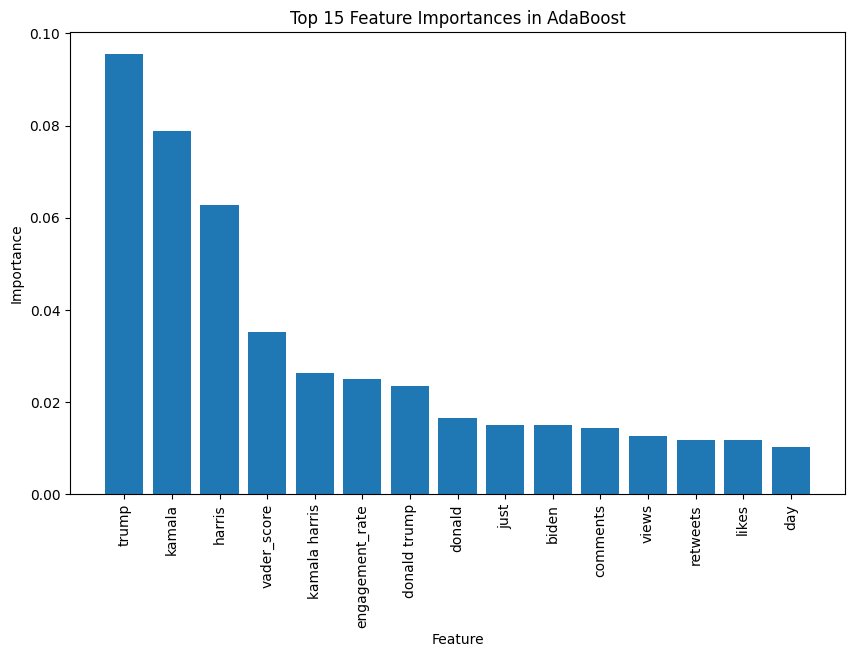

In [209]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance from AdaBoost model
feature_importances = model.feature_importances_
feature_names = X_train.columns  # Get feature names

# Sort features by importance (descending order)
indices = np.argsort(feature_importances)[::-1]

# Select top 15 features
top_n = 15
top_indices = indices[:top_n]
top_features = np.array(feature_names)[top_indices]
top_importances = feature_importances[top_indices]

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances in AdaBoost")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

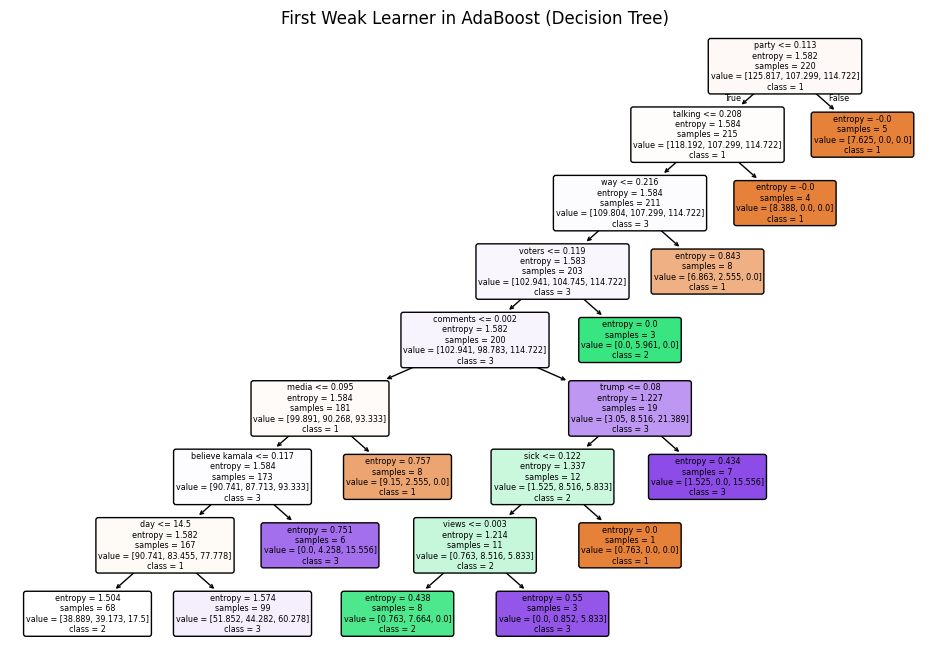

In [210]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get first weak learner (decision tree)
first_tree = model.estimators_[0]

# Dynamically extract class names from Y_train
class_labels = [str(label) for label in np.unique(Y_train)]

# Ensure it's a Decision Tree before plotting
if hasattr(first_tree, "tree_"):
    plt.figure(figsize=(12, 8))
    plot_tree(
        first_tree, 
        feature_names=X_train.columns, 
        class_names=class_labels,  # Use dynamically extracted class names
        filled=True, rounded=True
    )
    plt.title("First Weak Learner in AdaBoost (Decision Tree)")
    plt.show()
else:
    print("First weak learner is not a decision tree. Check AdaBoost configuration.")



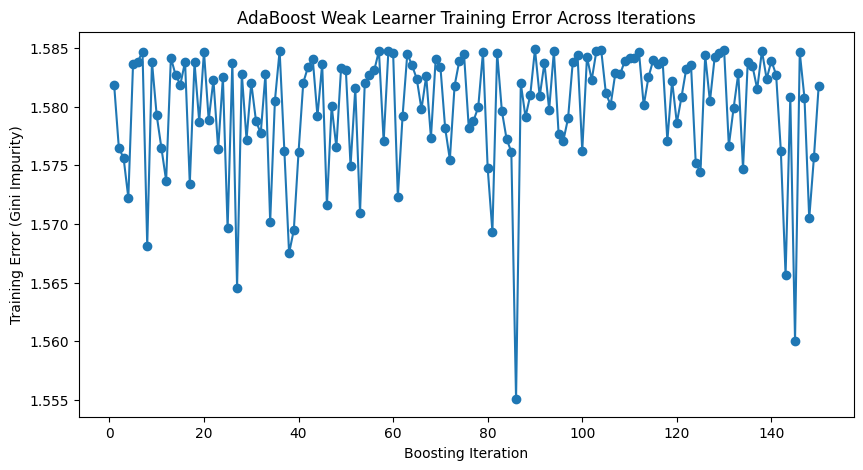

In [211]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the training errors from each weak learner
errors = np.array([estimator.tree_.impurity[0] for estimator in model.estimators_])

# Plot training error across boosting iterations
plt.figure(figsize=(10,5))
plt.plot(range(1, len(errors)+1), errors, marker='o', linestyle='-')
plt.xlabel("Boosting Iteration")
plt.ylabel("Training Error (Gini Impurity)")
plt.title("AdaBoost Weak Learner Training Error Across Iterations")
plt.show()



In [212]:
# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 3 to others
candidate_3_diff = feature_means_by_candidate.loc[3] - feature_means_by_candidate.loc[[1, 2]].mean()

# Show top differences
print(candidate_3_diff.sort_values(ascending=False).head(20))

August             0.080375
day                0.071411
November           0.036873
yall               0.030212
July               0.026029
post               0.019690
trump              0.019403
pretty             0.017773
believe trump      0.016071
mad                0.015399
million            0.014912
day                0.014572
crazy              0.014445
told               0.014343
convicted          0.013588
trump convicted    0.013588
legal              0.013343
chris              0.013308
supporting         0.013149
happens            0.013116
dtype: float64


In [213]:
import pandas as pd

# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 2 to Candidate 1
candidate_2_vs_1 = feature_means_by_candidate.loc[2] - feature_means_by_candidate.loc[1]
candidate_2_vs_1_sorted = candidate_2_vs_1.sort_values(ascending=False)

# Compare Candidate 1 to Candidate 2
candidate_1_vs_2 = feature_means_by_candidate.loc[1] - feature_means_by_candidate.loc[2]
candidate_1_vs_2_sorted = candidate_1_vs_2.sort_values(ascending=False)

# Convert to DataFrames for better readability
candidate_2_vs_1_df = candidate_2_vs_1_sorted.to_frame()
candidate_2_vs_1_df.columns = ["Difference (Candidate 2 - Candidate 1)"]

candidate_1_vs_2_df = candidate_1_vs_2_sorted.to_frame()
candidate_1_vs_2_df.columns = ["Difference (Candidate 1 - Candidate 2)"]

# Display the top 20 distinctive features for each comparison
print("🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:")
print(candidate_2_vs_1_df.head(20))

print("\n🔹 Features that appear more in Candidate 1's tweets than Candidate 2's:")
print(candidate_1_vs_2_df.head(20))

#overall trend (similar to direction) harris has more indirect related tweets while trump is more direct 
# for exmaple, harris as a lot of identifiers with biden, or walz while trump has win, election, etc

🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:
                Difference (Candidate 2 - Candidate 1)
day                                           0.890511
vader_score                                   0.118670
kamala                                        0.095862
harris                                        0.085368
July                                          0.056438
kamala harris                                 0.040380
biden                                         0.029793
October                                       0.025524
September                                     0.022470
think                                         0.016866
believe kamala                                0.016165
just                                          0.015143
think kamala                                  0.014262
believe harris                                0.013422
does                                          0.013378
kamalas                                       0.

In [214]:
########################################
# STEP 6: Evaluate on test set
########################################
X_train_f = pd.concat([X_train, X_val])
Y_train_f = pd.concat([Y_train, Y_val])
print("Shape:", X_train_f.shape)
# WARNING:
# this code should be run only once;
# after the hyperparameters have been decided based on the validation performance,
# then the False can be changed to True to run this code
if True:
    test_accuracy = model.score(X_test, Y_test)
    print(f"test_accuracy={test_accuracy}")

    y_test_pred = model.predict(X_test)

    # Compute test set metrics
    print("Test Set Metrics:")
    print(classification_report(Y_test, y_test_pred))

Shape: (425, 762)
test_accuracy=0.8
Test Set Metrics:
              precision    recall  f1-score   support

           1       0.74      0.97      0.84        33
           2       0.87      0.93      0.90        29
           3       1.00      0.08      0.14        13

    accuracy                           0.80        75
   macro avg       0.87      0.66      0.63        75
weighted avg       0.84      0.80      0.74        75



In [215]:
# Use the full original df_model (or df_model2 if it's updated)
df_all = df_model.reset_index(drop=True)

# 1. Reuse the trained TF-IDF vectorizer
X_all_tfidf = vectorizer.transform(df_all['fullText'])

# 2. Extract the same metadata features
drop_cols = ['fullText', 'Candidate', 'Sentiment', 'direction', 'id']
meta_features = [col for col in df_model.columns if col not in drop_cols]
X_all_meta = df_all[meta_features].reset_index(drop=True)

# 3. Combine TF-IDF and metadata into X_all
X_all = pd.concat([
    pd.DataFrame(X_all_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),
    X_all_meta
], axis=1)

y_all_pred = model.predict(X_all)

df_model2 = df_model.reset_index(drop=True)  # Match index to X_all
# Predict labels and probabilities
df_model2['candidate_pred'] = model.predict(X_all)
y_all_proba = model.predict_proba(X_all)

# Add 'confidence' column: probability of predicted class
df_model2['confidence'] = [
    row[model.classes_.tolist().index(pred)]
    for row, pred in zip(y_all_proba, df_model2['candidate_pred'])
]
df_model2[['fullText', 'Candidate', 'candidate_pred', 'confidence']].head()
df_model2['candidate_pred'] = y_all_pred

accuracy = (df_model2['Candidate'] == df_model2['candidate_pred']).mean()
print(f"Overall accuracy on full 500 samples: {accuracy:.4f}")

df_mistakes = df_model2[df_model2['Candidate'] != df_model2['candidate_pred']]
print(df_mistakes[['fullText', 'Candidate', 'candidate_pred', 'confidence']].head(10))





Overall accuracy on full 500 samples: 0.8780
                                             fullText  Candidate  \
7   cnn is reporting that officials believe that t...          3   
9   i believe it’s time to start making purchases ...          3   
32  so republicans are mad bc they (falsely) belie...          3   
35  let me get this straight: democrats lied to th...          3   
44  us political class wants us to believe ✌️unity...          3   
48       do you believe kamala harris is a gun owner?          3   
52   he is from my state and i dont believe that h...          2   
57  i think merchan would have kept the 9/18 sente...          3   
79  i believe one reason is no longer holding rall...          1   
83   but trump thinks he personally counts as seve...          2   

    candidate_pred  confidence  
7                1    0.454666  
9                1    0.430055  
32               2    0.414382  
35               2    0.561358  
44               1    0.452560  
48      

In [216]:
df_model2.head(5)

,fullText,day,July,August,September,October,November,likes,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment,vader_score,candidate_pred,confidence
0,i think what people aren’t taking about enough...,14,0,1,0,0,0,0.000025,0.000010,0.000023,0.000019,0.020858,1,1,indirect,negative,-0.4404,1,0.438109
1,i can’t believe trump is really launching a pr...,13,0,0,0,1,0,0.000208,0.000052,0.000139,0.000889,0.035637,2,3,neutral,neutral,0.0000,3,0.409752
2,trump on the radio show sid & friends in the m...,7,0,0,0,1,0,0.000024,0.000062,0.000054,0.000057,0.011930,3,1,indirect,negative,0.9423,1,0.455462
3,most of these trump supporting men are lonely ...,21,0,0,1,0,0,0.000021,0.000010,0.000003,0.000019,0.117333,4,1,indirect,negative,-0.7003,1,0.489305
4,i think weve all confused jerry brown with wil...,9,0,1,0,0,0,0.000178,0.000146,0.000071,0.000227,0.053209,5,3,neutral,neutral,0.0516,3,0.416388


In [217]:
########################
# split data
########################
df_model2 = df_model2[df_model2["Candidate"] != 3]
df_model2 = pd.get_dummies(df_model2, columns=['candidate_pred'], prefix='candidate_pred')
df_model2 = df_model2.drop(columns = ['Candidate'])
df_model2['Sentiment'] = df_model2['Sentiment'].str.strip().str.lower()  # Remove spaces & lowercase
candidate_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
df_model2['Sentiment'] = df_model2['Sentiment'].map(candidate_mapping)
df_model2['Sentiment'] = df_model2['Sentiment'].fillna(1).astype(int)
df_model2.head(5)
x_train2 = df_model2.drop(columns=['Sentiment', 'direction', 'id', 'confidence'])

y_train2 = df_model2['Sentiment'].reset_index(drop=True)

# Step 7: Verify Final Data
print("Final x_train shape:", x_train2.shape)
print("Final y_train shape:", y_train2.shape)
print(x_train2.head()) 
print(y_train2.head())

Final x_train shape: (414, 15)
Final y_train shape: (414,)
                                            fullText  day  July  August  \
0  i think what people aren’t taking about enough...   14     0       1   
2  trump on the radio show sid & friends in the m...    7     0       0   
3  most of these trump supporting men are lonely ...   21     0       0   
6  if you believe kamalas policies will bring dow...   11     0       0   
8  i know its early and its foolish for me to say...   19     0       0   

   September  October  November     likes  retweets     views  comments  \
0          0        0         0  0.000025  0.000010  0.000023  0.000019   
2          0        1         0  0.000024  0.000062  0.000054  0.000057   
3          1        0         0  0.000021  0.000010  0.000003  0.000019   
6          1        0         0  0.000331  0.000489  0.000042  0.000170   
8          0        1         0  0.002815  0.001663  0.000522  0.002100   

   engagement_rate  vader_score  candid

In [218]:
########################################
# Create train/test sets
########################################

from sklearn.model_selection import train_test_split

# Step 1: Split into train + test
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    x_train2, y_train2, test_size=0.20, random_state=42, stratify=y_train2  # <- fix here
)

# Step 2: Split train into train + validation
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(
    X_train2, Y_train2, test_size=0.25, random_state=42, stratify=Y_train2
)

# Print new distributions
print("New Training Class Distribution:\n", Y_train2.value_counts(normalize=True))
print("\nNew Validation Class Distribution:\n", Y_val2.value_counts(normalize=True))
print("\nNew Test Class Distribution:\n", Y_test2.value_counts(normalize=True))

# Print final shapes
print(f"Training set: X_train={X_train2.shape}, Y_train={Y_train2.shape}")
print(f"Validation set: X_val={X_val2.shape}, Y_val={Y_val2.shape}")
print(f"Test set: X_test={X_test2.shape}, Y_test={Y_test2.shape}")

New Training Class Distribution:
 Sentiment
-1    0.705645
 1    0.294355
Name: proportion, dtype: float64

New Validation Class Distribution:
 Sentiment
-1    0.698795
 1    0.301205
Name: proportion, dtype: float64

New Test Class Distribution:
 Sentiment
-1    0.710843
 1    0.289157
Name: proportion, dtype: float64
Training set: X_train=(248, 15), Y_train=(248,)
Validation set: X_val=(83, 15), Y_val=(83,)
Test set: X_test=(83, 15), Y_test=(83,)


In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import pandas as pd

# ---- TF-IDF (Don't refit, reuse trained vectorizer) ----
X_train2_tfidf = vectorizer.transform(X_train2['fullText'])
X_val2_tfidf   = vectorizer.transform(X_val2['fullText'])
X_test2_tfidf  = vectorizer.transform(X_test2['fullText'])

# ---- Extract Metadata ----
drop_cols = ['fullText', 'Candidate', 'Sentiment', 'direction', 'id']
meta_features = [col for col in X_train2.columns if col not in drop_cols]

X_train2_meta = X_train2[meta_features].reset_index(drop=True)
X_val2_meta   = X_val2[meta_features].reset_index(drop=True)
X_test2_meta  = X_test2[meta_features].reset_index(drop=True)

# ---- Combine TF-IDF + Metadata ----
X_train2_final = pd.concat([
    pd.DataFrame(X_train2_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),
    X_train2_meta
], axis=1)

X_val2_final = pd.concat([
    pd.DataFrame(X_val2_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),
    X_val2_meta
], axis=1)

X_test2_final = pd.concat([
    pd.DataFrame(X_test2_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),
    X_test2_meta
], axis=1)

# ---- Standard Scaling ----
standardizer = StandardScaler(with_mean=True, with_std=True)
standardizer.fit(X_train2_final)  # Fit ONLY on training set

X_train2_scaled = standardizer.transform(X_train2_final)
X_val2_scaled   = standardizer.transform(X_val2_final)
X_test2_scaled  = standardizer.transform(X_test2_final)

# ---- MaxAbs Scaling ----
scaler = MaxAbsScaler()
scaler.fit(X_train2_scaled)  # Fit ONLY on training set

X_train2_final_scaled = scaler.transform(X_train2_scaled)
X_val2_final_scaled   = scaler.transform(X_val2_scaled)
X_test2_final_scaled  = scaler.transform(X_test2_scaled)

# Drop unnecessary columns after using them for TF-IDF
X_train2_cleaned = X_train2.drop(columns=['fullText', 'Candidate', 'direction', 'id'], errors='ignore')
X_val2_cleaned   = X_val2.drop(columns=['fullText', 'Candidate', 'direction', 'id'], errors='ignore')
X_test2_cleaned  = X_test2.drop(columns=['fullText', 'Candidate', 'direction', 'id'], errors='ignore')

# Optional: Preview a portion of the cleaned set
print(X_train2_cleaned.head())
print(Y_train2)


# ---- Final check ----
print(f"X_train2_final_scaled shape: {X_train2_final_scaled.shape}")
print(f"X_val2_final_scaled shape:   {X_val2_final_scaled.shape}")
print(f"X_test2_final_scaled shape:  {X_test2_final_scaled.shape}")

X_train2_feature_names = X_train2_final.columns.tolist()




     day  July  August  September  October  November     likes  retweets  \
303   27     0       0          1        0         0  0.000022  0.000042   
130   17     0       1          0        0         0  0.000258  0.000021   
443   17     0       0          0        1         0  0.001791  0.003430   
259   28     0       0          0        1         0  0.004553  0.001102   
147    1     0       0          0        0         1  0.014982  0.005478   

        views  comments  engagement_rate  vader_score  candidate_pred_1  \
303  0.000005  0.000057         0.111727      -0.8658             False   
130  0.000067  0.000208         0.070970       0.1522             False   
443  0.000177  0.002251         0.240420      -0.8715             False   
259  0.001475  0.000567         0.055797      -0.6240              True   
147  0.014297  0.071958         0.025987      -0.6964              True   

     candidate_pred_2  
303              True  
130              True  
443              Tru

In [220]:
########################################
# Train a model
########################################
from sklearn.metrics import classification_report


# MODELS
svm_model = sklearn.svm.SVC(
    C=10,
    kernel='rbf',
    degree=3,
    gamma=0.1,
    tol=1e-3,
    max_iter=2000,
    cache_size=200,
    random_state=42
)

sentiment_model = sklearn.ensemble.AdaBoostClassifier(
    estimator=sklearn.tree.DecisionTreeClassifier(
        criterion= 'gini',
        max_depth=7,
        max_features = 'sqrt',
        max_leaf_nodes=10,
        min_samples_leaf=2,
        min_samples_split=2,
        class_weight='balanced',  # optional
        random_state=42,
    ),
    n_estimators=35,
    learning_rate=0.5,
    random_state=42
)

model_rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=75,
    criterion='entropy',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    class_weight='balanced',
    random_state=42
)

# ✅ TRAIN all models on X_train2, Y_train2
sentiment_model.fit(X_train2_final_scaled, Y_train2)
svm_model.fit(X_train2_final_scaled, Y_train2)
model_rf.fit(X_train2_final_scaled, Y_train2)

# === DT Evaluation ===
print(f"\n📊 DT")
print(f"Validation Accuracy: {sentiment_model.score(X_val2_final_scaled, Y_val2):.4f}")
print(f"Train Accuracy: {sentiment_model.score(X_train2_final_scaled, Y_train2):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train2, sentiment_model.predict(X_train2_final_scaled)))
print("Validation Set Metrics:")
print(classification_report(Y_val2, sentiment_model.predict(X_val2_final_scaled)))

# === SVM Evaluation ===
print(f"\n📊 SVM")
print(f"Validation Accuracy: {svm_model.score(X_val2_final_scaled, Y_val2):.4f}")
print(f"Train Accuracy: {svm_model.score(X_train2_final_scaled, Y_train2):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train2, svm_model.predict(X_train2_final_scaled)))
print("Validation Set Metrics:")
print(classification_report(Y_val2, svm_model.predict(X_val2_final_scaled)))

# === Random Forest Evaluation ===
print(f"\n📊 Random Forest")
print(f"Validation Accuracy: {model_rf.score(X_val2_final_scaled, Y_val2):.4f}")
print(f"Train Accuracy: {model_rf.score(X_train2_final_scaled, Y_train2):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train2, model_rf.predict(X_train2_final_scaled)))
print("Validation Set Metrics:")
print(classification_report(Y_val2, model_rf.predict(X_val2_final_scaled)))



📊 DT
Validation Accuracy: 0.6506
Train Accuracy: 1.0000
Train Set Metrics:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        73

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248

Validation Set Metrics:
              precision    recall  f1-score   support

          -1       0.72      0.81      0.76        58
           1       0.39      0.28      0.33        25

    accuracy                           0.65        83
   macro avg       0.56      0.55      0.54        83
weighted avg       0.62      0.65      0.63        83


📊 SVM
Validation Accuracy: 0.7590
Train Accuracy: 1.0000
Train Set Metrics:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        73

    a

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from itertools import product

# Define your parameter grid
param_grid = {
    'n_estimators': [35, 55, 75, 100],            # AdaBoost
    'max_depth': [5, 7, 12, 15],                  # DecisionTree
    'min_samples_split': [2, 5],                 # DecisionTree
    'min_samples_leaf': [1, 2],                  # DecisionTree
    'max_features': ['sqrt', 'log2'],            # DecisionTree
    'criterion': ['gini', 'entropy']             # DecisionTree
}

# Create all combinations
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_model = None
best_score = 0
best_params = {}

for params in param_combinations:
    model = RandomForestClassifier(
        **params,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train2_final_scaled, Y_train2)
    score = model.score(X_val2_final_scaled, Y_val2)  # <-- your actual validation set
    
    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

print("✅ Best Params (based on validation):", best_params)
print("⭐ Best Validation Accuracy:", round(best_score, 4))



✅ Best Params (based on validation): {'n_estimators': 75, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy'}
⭐ Best Validation Accuracy: 0.747


In [222]:
from sklearn.svm import SVC

# Grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'linear']  # you could also test 'linear'
}

svm_keys, svm_values = zip(*svm_param_grid.items())
svm_combos = [dict(zip(svm_keys, v)) for v in product(*svm_values)]

best_svm_model = None
best_svm_score = 0
best_svm_params = {}

for params in svm_combos:
    svm_model = SVC(
        **params,
        tol=1e-3,
        max_iter=2000,
        cache_size=200,
        random_state=42    )
    svm_model.fit(X_train2_final_scaled, Y_train2)
    val_score = svm_model.score(X_val2_final_scaled, Y_val2)

    if val_score > best_svm_score:
        best_svm_score = val_score
        best_svm_model = svm_model
        best_svm_params = params

print("\n🔮 Best SVM Params:", best_svm_params)
print("⭐ Best SVM Validation Accuracy:", round(best_svm_score, 4))



🔮 Best SVM Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
⭐ Best SVM Validation Accuracy: 0.759


In [223]:
if True:
# DT
    model_rf.fit(X_train2_final_scaled, Y_train2)
    test_accuracy = model_rf.score(X_test2_final_scaled, Y_test2)
    print(f"RF test_accuracy={test_accuracy}")
    
    svm_model.fit(X_train2_final_scaled, Y_train2)
    test_accuracy = svm_model.score(X_test2_final_scaled, Y_test2)
    print(f"SVM test_accuracy={test_accuracy}")

    sentiment_model.fit(X_train2_final_scaled, Y_train2)
    test_accuracy = sentiment_model.score(X_test2_final_scaled, Y_test2)
    print(f"DT2 test_accuracy={test_accuracy}")

RF test_accuracy=0.7349397590361446
SVM test_accuracy=0.6385542168674698
DT2 test_accuracy=0.6385542168674698


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [224]:
# === STEP 1: TF-IDF from fullText ===
X_all_tfidf = vectorizer.transform(df_model2['fullText'])
X_all_tfidf_df = pd.DataFrame(X_all_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# === STEP 2: Metadata ===
drop_cols = ['fullText', 'Candidate', 'Sentiment', 'direction', 'id', 'confidence']
meta_features = [col for col in df_model2.columns if col not in drop_cols]
X_all_meta = df_model2[meta_features].reset_index(drop=True)

# === STEP 3: Combine TF-IDF and metadata ===
X_all_combined = pd.concat([X_all_tfidf_df, X_all_meta], axis=1)

# === STEP 4: Scale using training scalers ===
X_all_standardized = standardizer.transform(X_all_combined)
X_all_scaled = scaler.transform(X_all_standardized)

# === STEP 5: Done! Print shape ===
print(f"✅ Scaled full dataset shape: {X_all_scaled.shape}")

# === Predict sentiment class labels ===
y_pred = model_rf.predict(X_all_scaled)

# === Predict confidence scores (probability of predicted class) ===
y_proba = model_rf.predict_proba(X_all_scaled)

# === Attach to the original df_model2 (reset index just in case) ===
df_results = df_model2.reset_index(drop=True).copy()
df_results['sentiment_pred'] = y_pred

# Add confidence for the predicted class
df_results['confidence_sentiment'] = [
    row[model_rf.classes_.tolist().index(pred)]
    for row, pred in zip(y_proba, y_pred)
]
print(df_results[['fullText', 'Sentiment', 'sentiment_pred', 'confidence_sentiment']].head())

accuracy = (df_results['Sentiment'] == df_results['sentiment_pred']).mean()
print(f"✅ Final model accuracy on full data: {accuracy:.4f}")


✅ Scaled full dataset shape: (414, 764)
                                            fullText  Sentiment  \
0  i think what people aren’t taking about enough...         -1   
1  trump on the radio show sid & friends in the m...         -1   
2  most of these trump supporting men are lonely ...         -1   
3  if you believe kamalas policies will bring dow...         -1   
4  i know its early and its foolish for me to say...          1   

   sentiment_pred  confidence_sentiment  
0              -1              0.517415  
1               1              0.562148  
2              -1              0.541878  
3              -1              0.563764  
4               1              0.534720  
✅ Final model accuracy on full data: 0.8478


In [225]:
df_results.head(5)

df_model3 = df_results

df_model3.head(5)

,fullText,day,July,August,September,October,November,likes,retweets,views,...,engagement_rate,id,direction,Sentiment,vader_score,confidence,candidate_pred_1,candidate_pred_2,sentiment_pred,confidence_sentiment
0,i think what people aren’t taking about enough...,14,0,1,0,0,0,0.000025,0.000010,0.000023,...,0.020858,1,indirect,-1,-0.4404,0.438109,True,False,-1,0.517415
1,trump on the radio show sid & friends in the m...,7,0,0,0,1,0,0.000024,0.000062,0.000054,...,0.011930,3,indirect,-1,0.9423,0.455462,True,False,1,0.562148
2,most of these trump supporting men are lonely ...,21,0,0,1,0,0,0.000021,0.000010,0.000003,...,0.117333,4,indirect,-1,-0.7003,0.489305,True,False,-1,0.541878
3,if you believe kamalas policies will bring dow...,11,0,0,1,0,0,0.000331,0.000489,0.000042,...,0.168659,7,indirect,-1,0.2023,0.398374,False,True,-1,0.563764
4,i know its early and its foolish for me to say...,19,0,0,0,1,0,0.002815,0.001663,0.000522,...,0.106711,9,indirect,1,0.9460,0.658937,False,True,1,0.534720


In [226]:
########################
# split data
########################
df_model3 = pd.get_dummies(df_model3, columns=['sentiment_pred'], prefix='sentiment_pred')
df_model3 = df_model3.drop(columns=['Sentiment'], errors='ignore')
df_model3['direction'] = df_model3['direction'].str.strip().str.lower()
direction_mapping = {'direct': 1, 'indirect': 0}
df_model3['direction'] = df_model3['direction'].map(direction_mapping)
df_model3['direction'] = df_model3['direction'].fillna(1).astype(int)

x_train3 = df_model3.drop(columns=['direction', 'id', 'confidence', 'confidence_sentiment'], errors='ignore')
y_train3 = df_model3['direction'].reset_index(drop=True)

print("Final x_train shape:", x_train3.shape)
print("Final y_train shape:", y_train3.shape)
print(x_train3.head())
print(y_train3.head())


Final x_train shape: (414, 17)
Final y_train shape: (414,)
                                            fullText  day  July  August  \
0  i think what people aren’t taking about enough...   14     0       1   
1  trump on the radio show sid & friends in the m...    7     0       0   
2  most of these trump supporting men are lonely ...   21     0       0   
3  if you believe kamalas policies will bring dow...   11     0       0   
4  i know its early and its foolish for me to say...   19     0       0   

   September  October  November     likes  retweets     views  comments  \
0          0        0         0  0.000025  0.000010  0.000023  0.000019   
1          0        1         0  0.000024  0.000062  0.000054  0.000057   
2          1        0         0  0.000021  0.000010  0.000003  0.000019   
3          1        0         0  0.000331  0.000489  0.000042  0.000170   
4          0        1         0  0.002815  0.001663  0.000522  0.002100   

   engagement_rate  vader_score  candid

In [227]:
########################################
# Create train/test sets
########################################

from sklearn.model_selection import train_test_split

# Step 1: Split into train + test
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(
    x_train3, y_train3, test_size=0.20, random_state=42, stratify=y_train3  # <- fix here
)

# Step 2: Split train into train + validation
X_train3, X_val3, Y_train3, Y_val3 = train_test_split(
    X_train3, Y_train3, test_size=0.25, random_state=42, stratify=Y_train3
)

# Print new distributions
print("New Training Class Distribution:\n", Y_train3.value_counts(normalize=True))
print("\nNew Validation Class Distribution:\n", Y_val3.value_counts(normalize=True))
print("\nNew Test Class Distribution:\n", Y_test3.value_counts(normalize=True))

# Print final shapes
print(f"Training set: X_train={X_train3.shape}, Y_train={Y_train3.shape}")
print(f"Validation set: X_val={X_val3.shape}, Y_val={Y_val3.shape}")
print(f"Test set: X_test={X_test3.shape}, Y_test={Y_test3.shape}")

New Training Class Distribution:
 direction
0    0.620968
1    0.379032
Name: proportion, dtype: float64

New Validation Class Distribution:
 direction
0    0.614458
1    0.385542
Name: proportion, dtype: float64

New Test Class Distribution:
 direction
0    0.614458
1    0.385542
Name: proportion, dtype: float64
Training set: X_train=(248, 17), Y_train=(248,)
Validation set: X_val=(83, 17), Y_val=(83,)
Test set: X_test=(83, 17), Y_test=(83,)


In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import pandas as pd

# ---- TF-IDF (Don't refit, reuse trained vectorizer) ----
X_train3_tfidf = vectorizer.transform(X_train3['fullText'])
X_val3_tfidf   = vectorizer.transform(X_val3['fullText'])
X_test3_tfidf  = vectorizer.transform(X_test3['fullText'])

# ---- Extract Metadata ----
drop_cols = ['fullText', 'Candidate', 'Sentiment', 'direction', 'id']
meta_features = [col for col in X_train3.columns if col not in drop_cols]

X_train3_meta = X_train3[meta_features].reset_index(drop=True)
X_val3_meta   = X_val3[meta_features].reset_index(drop=True)
X_test3_meta  = X_test3[meta_features].reset_index(drop=True)

# ---- Combine TF-IDF + Metadata ----
X_train3_final = pd.concat([
    pd.DataFrame(X_train3_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),
    X_train3_meta
], axis=1)

X_val3_final = pd.concat([
    pd.DataFrame(X_val3_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),
    X_val3_meta
], axis=1)

X_test3_final = pd.concat([
    pd.DataFrame(X_test3_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),
    X_test3_meta
], axis=1)

# ---- Standard Scaling ----
standardizer = StandardScaler(with_mean=True, with_std=True)
standardizer.fit(X_train3_final)  # Fit ONLY on training set

X_train3_scaled = standardizer.transform(X_train3_final)
X_val3_scaled   = standardizer.transform(X_val3_final)
X_test3_scaled  = standardizer.transform(X_test3_final)

# ---- MaxAbs Scaling ----
scaler = MaxAbsScaler()
scaler.fit(X_train3_scaled)  # Fit ONLY on training set

X_train3_final_scaled = scaler.transform(X_train3_scaled)
X_val3_final_scaled   = scaler.transform(X_val3_scaled)
X_test3_final_scaled  = scaler.transform(X_test3_scaled)

# Drop unnecessary columns after using them for TF-IDF
X_train3_cleaned = X_train3.drop(columns=['fullText', 'Candidate', 'direction', 'id'], errors='ignore')
X_val3_cleaned   = X_val3.drop(columns=['fullText', 'Candidate', 'direction', 'id'], errors='ignore')
X_test3_cleaned  = X_test3.drop(columns=['fullText', 'Candidate', 'direction', 'id'], errors='ignore')

# Optional: Preview a portion of the cleaned set
print(X_train3_cleaned.head())
print(Y_train3)


# ---- Final check ----
print(f"X_train3_final_scaled shape: {X_train3_final_scaled.shape}")
print(f"X_val3_final_scaled shape:   {X_val3_final_scaled.shape}")
print(f"X_test3_final_scaled shape:  {X_test3_final_scaled.shape}")

#X_train3_feature_names = X_train3_final.columns.tolist()




     day  July  August  September  October  November     likes  retweets  \
163   16     0       0          0        1         0  0.001604  0.001538   
223   30     0       1          0        0         0  0.000088  0.000031   
210   21     0       0          0        1         0  0.000054  0.000146   
64    10     0       1          0        0         0  0.000022  0.000094   
173   14     0       1          0        0         0  0.000235  0.000249   

        views  comments  engagement_rate  vader_score  candidate_pred_1  \
163  0.000605  0.000908         0.054227      -0.8880              True   
223  0.000045  0.000303         0.045267       0.7096              True   
210  0.000045  0.000113         0.032336       0.8519             False   
64   0.000007  0.000076         0.107168      -0.8020              True   
173  0.000034  0.000208         0.145635      -0.1027              True   

     candidate_pred_2  sentiment_pred_-1  sentiment_pred_1  
163             False          

In [229]:
########################################
# Train a model
########################################
from sklearn.metrics import classification_report


# MODELS
svm_model = sklearn.svm.SVC(
    C=10,
    kernel='rbf',
    degree=3,
    gamma='scale',
    tol=1e-3,
    max_iter=2000,
    cache_size=200,
    random_state=42
)

sentiment_model = sklearn.ensemble.AdaBoostClassifier(
    estimator=sklearn.tree.DecisionTreeClassifier(
        criterion= 'gini',
        max_depth=3,
        max_features = 'sqrt',
        max_leaf_nodes=10,
        min_samples_leaf=2,
        min_samples_split=2,
        class_weight='balanced',  # optional
        random_state=42,
    ),
    n_estimators=25,
    learning_rate=1,
    random_state=42
)

model_rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

# ✅ TRAIN all models on X_train2, Y_train2
sentiment_model.fit(X_train3_final_scaled, Y_train3)
svm_model.fit(X_train3_final_scaled, Y_train3)
model_rf.fit(X_train3_final_scaled, Y_train3)

# === DT Evaluation ===
print(f"\n📊 DT")
print(f"Validation Accuracy: {sentiment_model.score(X_val3_final_scaled, Y_val3):.4f}")
print(f"Train Accuracy: {sentiment_model.score(X_train3_final_scaled, Y_train3):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train3, sentiment_model.predict(X_train3_final_scaled)))
print("Validation Set Metrics:")
print(classification_report(Y_val3, sentiment_model.predict(X_val3_final_scaled)))

# === SVM Evaluation ===
print(f"\n📊 SVM")
print(f"Validation Accuracy: {svm_model.score(X_val3_final_scaled, Y_val3):.4f}")
print(f"Train Accuracy: {svm_model.score(X_train3_final_scaled, Y_train3):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train3, svm_model.predict(X_train3_final_scaled)))
print("Validation Set Metrics:")
print(classification_report(Y_val3, svm_model.predict(X_val3_final_scaled)))

# === Random Forest Evaluation ===
print(f"\n📊 Random Forest")
print(f"Validation Accuracy: {model_rf.score(X_val3_final_scaled, Y_val3):.4f}")
print(f"Train Accuracy: {model_rf.score(X_train3_final_scaled, Y_train3):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train3, model_rf.predict(X_train3_final_scaled)))
print("Validation Set Metrics:")
print(classification_report(Y_val3, model_rf.predict(X_val3_final_scaled)))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



📊 DT
Validation Accuracy: 0.4940
Train Accuracy: 0.9839
Train Set Metrics:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       154
           1       0.99      0.97      0.98        94

    accuracy                           0.98       248
   macro avg       0.98      0.98      0.98       248
weighted avg       0.98      0.98      0.98       248

Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59        51
           1       0.34      0.34      0.34        32

    accuracy                           0.49        83
   macro avg       0.47      0.47      0.47        83
weighted avg       0.49      0.49      0.49        83


📊 SVM
Validation Accuracy: 0.6627
Train Accuracy: 1.0000
Train Set Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       154
           1       1.00      1.00      1.00        94

    a

In [230]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from itertools import product

param_grid = {
    'n_estimators': [35, 55, 75, 100],
    'max_depth': [5, 7, 12, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_model = None
best_score = 0
best_params = {}

for params in param_combinations:
    model = RandomForestClassifier(
        **params,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train3_final_scaled, Y_train3)  # Or X_train3_split if you split
    y_val_pred = model.predict(X_val3_final_scaled)
    score = accuracy_score(Y_val3, y_val_pred)

    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

print("✅ Best Params (based on validation):", best_params)
print("⭐ Best Validation Accuracy:", round(best_score, 4))


✅ Best Params (based on validation): {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}
⭐ Best Validation Accuracy: 0.6506


In [231]:
from sklearn.svm import SVC

# Grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'linear']  # you could also test 'linear'
}

svm_keys, svm_values = zip(*svm_param_grid.items())
svm_combos = [dict(zip(svm_keys, v)) for v in product(*svm_values)]

best_svm_model = None
best_svm_score = 0
best_svm_params = {}

for params in svm_combos:
    svm_model = SVC(
        **params,
        tol=1e-3,
        max_iter=2000,
        cache_size=200,
        random_state=42    )
    svm_model.fit(X_train3_final_scaled, Y_train3)
    val_score = svm_model.score(X_val3_final_scaled, Y_val3)

    if val_score > best_svm_score:
        best_svm_score = val_score
        best_svm_model = svm_model
        best_svm_params = params

print("\n🔮 Best SVM Params:", best_svm_params)
print("⭐ Best SVM Validation Accuracy:", round(best_svm_score, 4))



🔮 Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
⭐ Best SVM Validation Accuracy: 0.6627


In [232]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from itertools import product

# Define hyperparameter grid
param_grid = {
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.1, 0.5, 1.0],
    'base_max_depth': [3, 5, 7],
    'base_min_samples_leaf': [1, 2],
    'base_max_features': ['sqrt', 'log2']
}

# Create all combinations
keys, values = zip(*param_grid.items())
param_combos = [dict(zip(keys, v)) for v in product(*values)]

best_adaboost = None
best_score = 0
best_params = {}

for params in param_combos:
    base_dt = DecisionTreeClassifier(
        max_depth=params['base_max_depth'],
        min_samples_leaf=params['base_min_samples_leaf'],
        max_features=params['base_max_features'],
        class_weight='balanced',
        random_state=42
    )
    
    ada_model = AdaBoostClassifier(
        estimator=base_dt,
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        random_state=42
    )
    
    ada_model.fit(X_train3_final_scaled, Y_train3)
    y_val_pred = ada_model.predict(X_val3_final_scaled)
    score = accuracy_score(Y_val3, y_val_pred)
    
    if score > best_score:
        best_score = score
        best_adaboost = ada_model
        best_params = params

print("🔥 Best AdaBoost Params:", best_params)
print("✅ Best AdaBoost Validation Accuracy:", round(best_score, 4))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

🔥 Best AdaBoost Params: {'n_estimators': 25, 'learning_rate': 1.0, 'base_max_depth': 3, 'base_min_samples_leaf': 2, 'base_max_features': 'sqrt'}
✅ Best AdaBoost Validation Accuracy: 0.6627


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [233]:
if True:
# DT
    model_rf.fit(X_train3_final_scaled, Y_train3)
    test_accuracy = model_rf.score(X_test3_final_scaled, Y_test3)
    print(f"RF test_accuracy={test_accuracy}")
    
    svm_model.fit(X_train3_final_scaled, Y_train3)
    test_accuracy = svm_model.score(X_test3_final_scaled, Y_test3)
    print(f"SVM test_accuracy={test_accuracy}")

    sentiment_model.fit(X_train3_final_scaled, Y_train3)
    test_accuracy = sentiment_model.score(X_test3_final_scaled, Y_test3)
    print(f"DT2 test_accuracy={test_accuracy}")

RF test_accuracy=0.5783132530120482
SVM test_accuracy=0.46987951807228917
DT2 test_accuracy=0.5662650602409639


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
